In [1]:
load('hipp_data.mat');

# Initial Plots of Spiking Activity

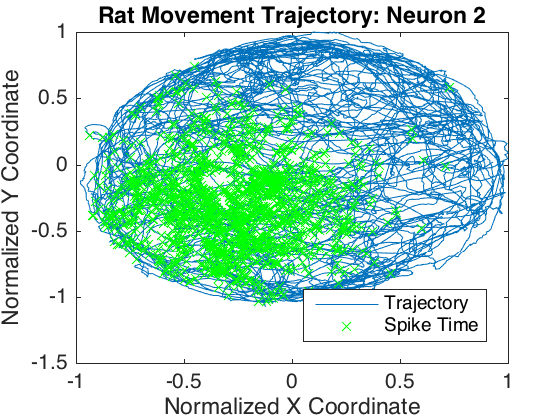

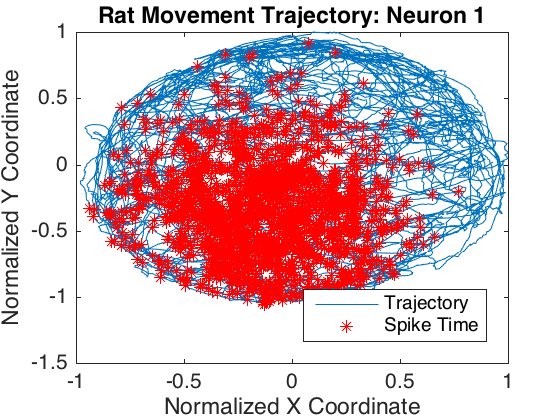

In [6]:
numSamples = length(T);
sampleFreq = 1000; % 1000 Hz if each bin is 1ms
figure();plot(xN,yN);title('Rat Movement Trajectory: Neuron 1');
xlabel('Normalized X Coordinate');ylabel('Normalized Y Coordinate');
hold on;
scatter(xN(spikes==1),yN(spikes==1),'r*');
legend('Trajectory','Spike Time','Location','southeast');

figure();plot(xN,yN);title('Rat Movement Trajectory: Neuron 2');
xlabel('Normalized X Coordinate');ylabel('Normalized Y Coordinate');
hold on;
scatter(xN(spikes2==1),yN(spikes2==1),'gx');
legend('Trajectory','Spike Time','Location','southeast');

Both neuron 1 and neuron 2 appear to fire more often at the same location in space ~(X,Y) = (-0.1,-0.5). That is, their firing rate is modulated by the animal's location in space. The size of the environment appears to have blocked us from observing the full extent of this "firing field", especially for neuron 1. Despite this limitation, it appears that the number of spikes at each location decays as the Euclidean distance from the center of mass of firing (-0.1,-0.5) increases.

# GLM

In [7]:
[b,dev,stats] = glmfit([xN yN],spikes,'poisson');
AIC = dev+2*length(b);
display('Exponential Linear Model: LAMBDA = exp(b0+b1*X+b2*Y)');
Table = table(b,stats.se,stats.p,'RowNames',{'b0','b1','b2'},'VariableNames',{'Value','Standard_Error','p_value'});
display(Table);
display(sprintf('Deviance: %3.2f',dev));
display(sprintf('AIC: %3.2f',AIC));

Exponential Linear Model: LAMBDA = exp(b0+b1*X+b2*Y)

Table = 

           Value      Standard_Error      p_value  
          ________    ______________    ___________

    b0     -3.2492    0.027597                    0
    b1    -0.50622    0.047236           8.4817e-27
    b2     -1.1801    0.044767          3.8524e-153

Deviance: 11388.16
AIC: 11394.16


Looking at the standard errors and the p-values, we see that all of the parameters are significantly different from zero. 

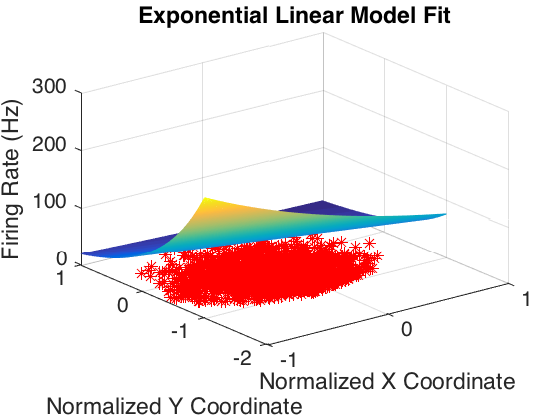

In [8]:
[X,Y] = meshgrid(-1:0.01:1,-1:0.01:1);
lambdaT = sampleFreq.*exp(b(1)+b(2).*X+b(3).*Y);
figure();
mesh(X,Y,lambdaT);title('Exponential Linear Model Fit');
hold on;
scatter(xN(spikes==1),yN(spikes==1),'r*');
xlabel('Normalized X Coordinate');ylabel('Normalized Y Coordinate');
zlabel('Firing Rate (Hz)');

This model shows an exponentially decaying firing rate, which reaches a maximum beyond the confines of the rat's environment (here at ~ (-1,-1)). It is clear that this model does not capture the circular/radial structure of the firing field shown in the initial images. The model will probably require x^2 and y^2 terms to be able to capture that structure.

# Quadratic Improvement to Previous GLM

In [9]:
[bquad,devquad,statsquad] = glmfit([xN yN xN.*yN xN.*xN yN.*yN],spikes,'poisson');
AICquad = devquad+2*length(bquad);
display('Exponential Quadratic Model: LAMBDA = exp(b0+b1*X+b2*Y+b3*XY+b4*XX+b5*YY)');
Table = table(bquad,statsquad.se,statsquad.p,'RowNames',{'b0','b1','b2','b3','b4','b5'},'VariableNames',{'Value','Standard_Error','p_value'});
display(Table);
display(sprintf('Deviance: %3.2f',devquad));
display(sprintf('AIC: %3.2f',AICquad));

Exponential Quadratic Model: LAMBDA = exp(b0+b1*X+b2*Y+b3*XY+b4*XX+b5*YY)

Table = 

           Value     Standard_Error      p_value  
          _______    ______________    ___________

    b0    -1.8246    0.038318                    0
    b1    -1.4905     0.12021           2.6523e-35
    b2    -2.4262     0.10155          3.8579e-126
    b3    -0.1187     0.23913              0.61963
    b4    -5.8179     0.19859          1.1482e-188
    b5    -3.6674       0.135          1.6835e-162

Deviance: 9141.22
AIC: 9153.22


Here, all of the parameters are significantly different from zero except for b3, which corresponds to the X*Y term. The rest are highly significant, given their extremely low p-values. This model also has a dramatically lower AIC than the exponential linear model, indicating it improves the description of this neuron's spatial firing properties.

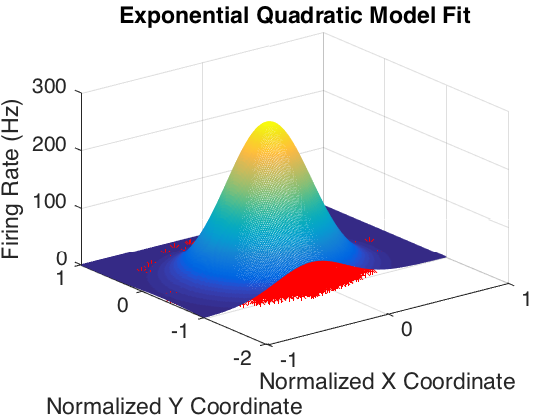

In [10]:
[X,Y] = meshgrid(-1:0.01:1,-1:0.01:1);
lambdaT = sampleFreq.*exp(bquad(1)+bquad(2).*X+bquad(3).*Y+bquad(4).*X.*Y+bquad(5).*X.*X+bquad(6).*Y.*Y);
figure();mesh(X,Y,lambdaT);title('Exponential Quadratic Model Fit');
hold on;
scatter(xN(spikes==1),yN(spikes==1),'r*');
xlabel('Normalized X Coordinate');ylabel('Normalized Y Coordinate');
zlabel('Firing Rate (Hz)');

Given this mesh plot and the greatly reduced AIC, this model describes the data much better than the previous model. Note: there may be some issue with the timing here as the firing rate is far higher than normal for any neuron. If each bin is truly 1ms, however, this is accurate.

# Include Spiking History

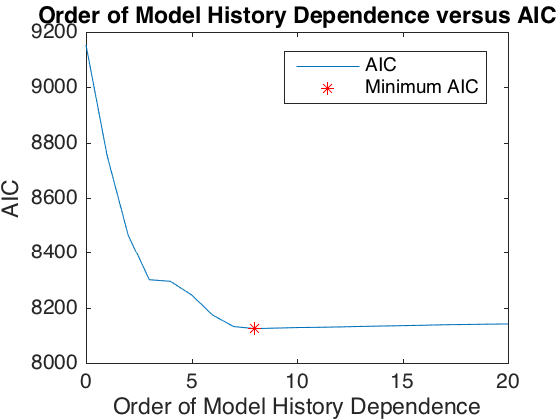

In [11]:
order = 1:20;
AICvec = zeros(length(order)+1,1);
AICvec(1) = AICquad;

for p=order
   [~,dev,~] = glmfit([xN yN xN.*xN yN.*yN spikes_hist(:,1:p)],spikes,'poisson');
  AICvec(p+1) = dev+2*(5+p);
end
order = [0,order];
figure();plot(order,AICvec);title('Order of Model History Dependence versus AIC');
xlabel('Order of Model History Dependence');ylabel('AIC');
[minAIC,index] = min(AICvec);
optimalOrder = index-1;
hold on;scatter(optimalOrder,minAIC,'r*');
legend('AIC','Minimum AIC');

The optimal model order, in terms of the neuron's own history dependence, is 8. This model includes the exponential quadratic model from above (with the xN*yN term removed), along with the spiking history of the neuron between 1 and 8 ms into the past. Thus, the probability of the neuron firing an action potential is significantly modulated for 8 ms following an action potential.

# Augmented Model with Spiking History of the other Neuron

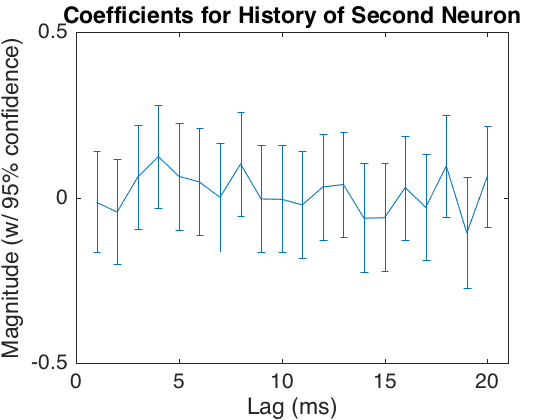

In [12]:
[b,dev,stats] = glmfit([xN yN xN.*xN yN.*yN spikes_hist(:,1:optimalOrder) spikes2_hist],spikes,'poisson');
interactionCoeffs = b(end-19:end);
interactionErrors = stats.se(end-19:end);
figure();errorbar(1:20,interactionCoeffs,2.*interactionErrors);
title('Coefficients for History of Second Neuron');
xlabel('Lag (ms)');ylabel('Magnitude (w/ 95% confidence)');
axis([0 21 -0.5 0.5]);

This plot shows the coefficients for the spiking history of neuron 2 in the augmented model. The error bars show approximate 95% confidence bounds on the maximum likelihood estimate. It is clear from this figure that none of the parameters is significantly different from zero. We might conclude that the spiking history of neuron 2 does not significantly affect the present spiking activity of neuron 1. 

The most parsimonious of all the models, which sufficiently describes the data, is the model with 13 parameters. Parameter 1 is the intercept, 2 is for the x position, 3 the y position, 4 the x position squared, 5 the y position squared, and the remaining 8 for the spiking history of the neuron between lags of 1 and 8 ms. We could argue that a more parsimonious model would only include the lags between 1 and 3 ms, given the shape of the AIC curve above. However, I'll take the model with the minimum AIC as the most parsimonious.

# GLM with only history and network interactions

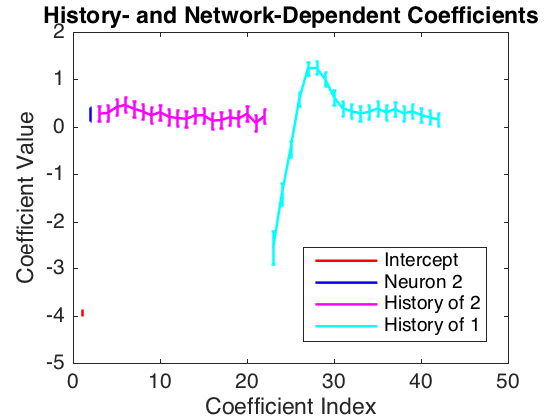

Exponential Spike History and Neighbor History Model

Table = 

            Value      Standard_Error     p_value  
           ________    ______________    __________

    b0      -3.9441    0.037467                   0
    b1      0.26914    0.075773          0.00038247
    b2      0.27876    0.079158           0.0004289
    b3      0.29396    0.081338          0.00030148
    b4      0.41777    0.079938          1.7307e-07
    b5      0.46195    0.078785          4.5332e-09
    b6       0.3807    0.081313          2.8423e-06
    b7      0.32714    0.082004           6.626e-05
    b8      0.24327    0.082782           0.0032955
    b9      0.31116    0.079771           9.594e-05
    b10     0.21561    0.083317           0.0096585
    b11     0.18456    0.082982            0.026139
    b12     0.17017    0.083224            0.040883
    b13     0.24059    0.080731           0.0028809
    b14     0.24552    0.081144           0.0024797
    b15     0.13229    0.084661             0.11816

In [13]:
[b,dev,stats] = glmfit([spikes2 spikes2_hist spikes_hist],spikes,'poisson');
AIC = dev+2*42;
display('Exponential Spike History and Neighbor History Model');
coeffNames = cell(42,1);
for ii=1:42
    coeffNames{ii} = sprintf('b%d',ii-1);
end
Table = table(b,stats.se,stats.p,'RowNames',coeffNames,'VariableNames',{'Value','Standard_Error','p_value'});
display(Table);
display(sprintf('AIC: %3.2f',AIC));
figure();errorbar(1,b(1),2.*stats.se(1),'r','LineWidth',1.2);
hold on;
errorbar(2,b(2),2.*stats.se(2),'b','LineWidth',1.2);
errorbar(3:22,b(3:22),2.*stats.se(3:22),'m','LineWidth',1.2);
errorbar(23:42,b(23:42),2.*stats.se(23:42),'c','LineWidth',1.2);
legend('Intercept','Neuron 2','History of 2','History of 1','Location','southeast');
title('History- and Network-Dependent Coefficients');xlabel('Coefficient Index');
ylabel('Coefficient Value');

From the table and the above plot, we see that most of the coefficients in this model are significantly different from zero. From this, we might conclude that the spiking of neuron 2 modulates the spiking of neuron 1. All of the coefficients relating the history of neuron 2 to the spiking of neuron 1 are greater than zero, indicating that a spike in neuron 2 slightly increases the probability of a spike in neuron 1 at a given lag in the future. Especially notable is that the effect of the neuron 1's history. The first three coefficients, corresponding to lags of 1, 2, and 3 ms are much less than zero, indicating that this neuron is less likely to fire an action potential immediately after it has already fired one.

# KS Plot of Parsimonious Model

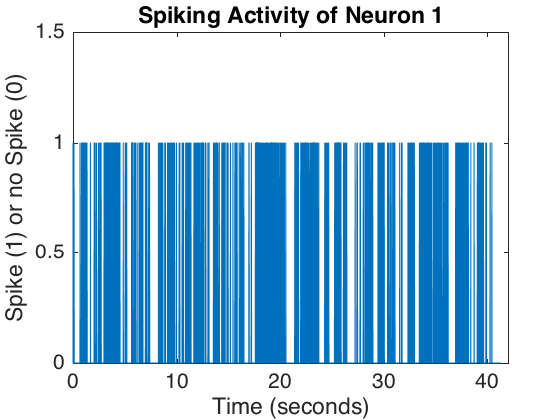

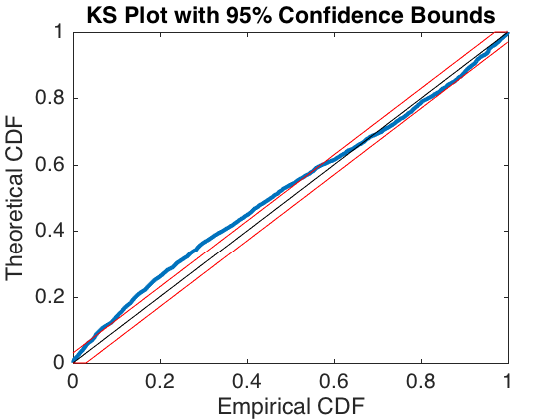

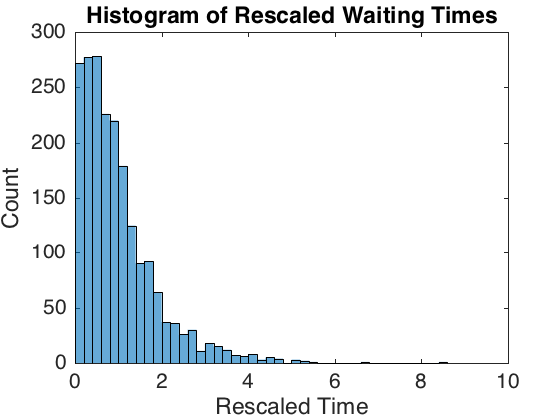

KS statistic: 0.065


In [35]:
% fit model with xN*yN term excluded and 8 lags for the neuron's spiking history
[b,~,~] = glmfit([xN yN xN.*xN yN.*yN spikes_hist(:,1:optimalOrder)],spikes,'poisson');
% get conditional intensity function
lambdaT = exp(b(1)+b(2).*xN+b(3).*yN+b(4).*xN.*xN+b(5).*yN.*yN+b(6).*spikes_hist(:,1)+b(7).*spikes_hist(:,2)+b(8).*spikes_hist(:,3)+b(9).*spikes_hist(:,4)+b(10).*spikes_hist(:,5)+b(11).*spikes_hist(:,6)+b(12).*spikes_hist(:,7)+b(13).*spikes_hist(:,8));

% get waiting times
numSpikes = sum(spikes);
Z = zeros(numSpikes,1);
indeces = find(spikes == 1);

lowInd = 1;
for ii=1:numSpikes
   Z(ii) = sum(lambdaT(lowInd:indeces(ii)));
   lowInd = indeces(ii)+1;
end
figure();histogram(Z);title('Histogram of Rescaled Waiting Times');
ylabel('Count');xlabel('Rescaled Time');

sortedISIs = sort(Z);
ISItimes = 0:0.01:max(sortedISIs);
eCDF = zeros(length(ISItimes),1);
for ii=1:length(ISItimes)
    eCDF(ii) = sum(sortedISIs <= ISItimes(ii));
end
eCDF = eCDF./numSpikes;

tCDF = 1-exp(-ISItimes');
bounds = (1.36/sqrt(numSpikes)).*ones(length(ISItimes),1);
figure();plot(eCDF,tCDF,'LineWidth',2);hold on;
xlabel('Empirical CDF');ylabel('Theoretical CDF');
title('KS Plot with 95% Confidence Bounds');

plot(tCDF,tCDF,'k');plot(tCDF,min(tCDF+bounds,1),'r');
plot(tCDF,max(tCDF-bounds,0),'r');hold off;

KSstat = max(abs(eCDF-tCDF));
display(sprintf('KS statistic: %3.3f',KSstat));

figure();plot((1:length(spikes))./1e3,spikes);axis([0 42 0 1.5]);title('Spiking Activity of Neuron 1');
xlabel('Time (seconds)');ylabel('Spike (1) or no Spike (0)');

We can see that the KS statistic representing the absolute maximum difference between the theoretical CDF and the empirical CDF falls beyond the 95% confidence bounds for the KS statistic's null distribution. This suggests that the model may not completely capture the observed spiking activity. The model appears to do quite well, given the plot of the exponential quadratic model above. However, there must be something missing that explains the poor fit. Perhaps, some other feature of the environment is relevant to this neuron's spiking activity: for example, the animal's location in relation to the environment's borders. Or, some visual, tactile, or olfactory cue is salient. The activity of other neurons, not recorded, is obviously crucial to this neuron's activity. Finally, the parsimonious model of spiking history, with only 8 lags, may have missed important statistical features of the spiking activity. Imagine that a string of densely-packed spikes for two seconds causes a subsequent lull in activity for another two seconds. This kind of higher-level history dependence is not accounted for in this model, which includes spiking history for only 8 milliseconds. There is some evidence of this kind of history dependence in the plot of spiking activity. We see that several of the most densely-packed periods of spiking are followed by long lulls of no spiking.